# Scientific Computing II

## Multigrid Methods

    
#### Anne Reinarz
#### Technical University of Munich
#### Summer 2020

# Part I
## Grid-based Methods

# Example

#### 1D Poisson Equation

$$ -\frac{d^2}{dx^2} u(x) = f(x), \text{ for } x\in [0,1]$$
$$u(0)=u(1)=0$$


- Discretise on a mesh of $N$ equidistant points $\rightarrow$ linear system to solve
- Recall Finite Difference Schemes (or see tutorial)

# Finite Elements – Main Ingredients

1. solve weak form of PDE to reduce regularity requirements
    $$ \int_0^1 \frac{d}{dx}u(x) \frac{d}{dx} v(x) dx = \int_0^1 f(x) v(x) dx $$
    
    $\rightarrow$ allows additional weak solutions    
    
    - must hold for all $v$ (taken from the same functionspace as $u$)

# Finite Elements - Main Ingredients

2. Discretisation: Restrict the search for the solution $u$ to some finite-dimensional subspace $V$.

    - Then we take a basis $\{b_i\}_i$ of $V$ and write the approximate solution $u_h$ using that basis.
        $$ u_h(x) = \sum_i u_i b_i(x)$$
    - New task: Find coefficients $u_i$ (don't depend on $x$) $\rightarrow$ back to solving a linear system

# Grid

#### Example: Equidistant grid points
$N$ grid points $\rightarrow$ mesh width $h=1/N$

$$[0,1] = \bigcup_{i=0}^{N-1} [x_i,x_{i+1}],\text{ where } x_i = i\cdot h$$

In [2]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.sparse import diags
from ipywidgets import interact, FloatSlider, IntSlider

from IPython.display import display, clear_output

fig, ax = plt.subplots()
plt.close(fig)

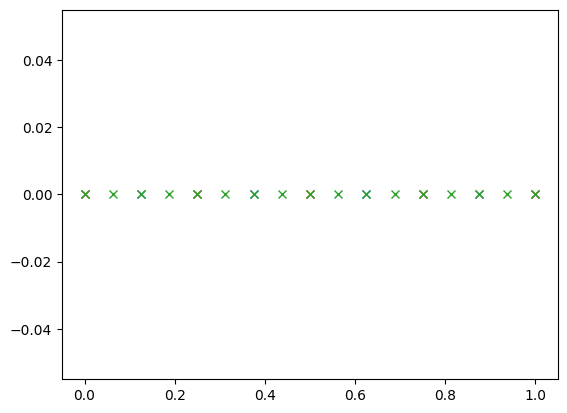

In [12]:
N = 17   # Number of grid points
h = 1/(N-1) # mesh width

xi = h*np.array(range(0,N))
ax.plot(xi, np.zeros(N),"x")
display(fig)

# Example: Nodal Basis

$$b_i(x) := \begin{cases}
\frac{1}{h} (x - x_{i-1} ),&x_{i-1} < x < x_i\\
\frac{1}{h} (x_{i+1} - x), &x_i < x < x_{i+1}\\
0,&\text{otherwise}
\end{cases}$$

In [3]:
ax.clear()
ax.set_xlim([0,1])
xi = h*np.array(range(0,N+1))

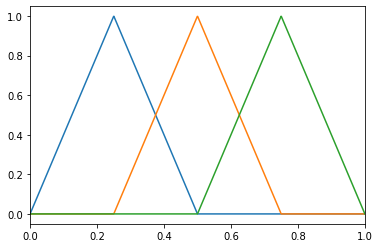

In [287]:
def b(x,i):
    if(x>xi[i-1] and x<xi[i]):
        return (N-1)*(x-xi[i-1])
    if(x>xi[i] and x<xi[i+1]):
        return (N-1)*(xi[i+1]-x)
    return 0

x = np.linspace(0,1,1000)
for i in range(1,N-1):
    ax.plot(x, [b(val,i) for val in x])
display(fig)

# Test and Shape Functions

- Recall: we search for solution functions $u_h$ of the form
 $$ u_h = \sum_i u_i b_i (x)$$
- the $b_i(x)$ are typically called shape or ansatz functions
- the basis functions $b_i(x)$ build a vector space (i.e., a function space) $V$
$$\text{span}\{b_1 , . . . , b_N \} = V$$

# Finite Elements - Main Ingredients

- insert into weak formulation:
- Find $N$ coefficients $u_i$ such that:
$$ \int_0^1 \sum_i[u_i b_i (x)]v dx = \int_0^1fv dx,~ \forall v \in V$$

#### How do we solve for all $v$?


# Finite Elements - Main Ingredients

#### Idea: Choose $v(x)= b_j(x)$

- Any $v$ can be written as a linear combination of basis functions $\rightarrow$ if the equation holds for all basis functions it holds for all $v$.

- Find $u_i$ such that
$$ \int_0^1 \sum_i[u_i b_i (x)]b_j(x) dx = \int_0^1f b_j(x) dx,~ \forall j\leq N$$

# Finite Elements - Main Ingredients

- we obtain a system of equations for unknowns $u_i$
- The functions $v=b_j$ are often referred to as test functions
- one equation for each test function $b_j$ $\rightarrow$ we then have as many equations as unknowns
- leads to system of linear equations $Au = f$ where

$$\sum_i u_i \underbrace{\int_0^1  \frac{d}{dx} b_i (x) \frac{d}{dx} b_j(x) dx}_{=A_{ij}} = \underbrace{\int_0^1f(x) b_j(x) dx}_{=f_j}$$

# Finite Elements - Main Ingredients

- In FD $f_j$ was just $f(x)$ evaluated at the node $x_j$, here it can be seen as a weighted average of the function $f$ in the support of $b_j$
$$\int_0^1 f(x) b_j(x) dx = \int_{x_{i-1}}^{x_i} f(x) \frac{1}{h} (x-x_{i-1})dx + \int_{x_{i}}^{x_{i+1}} f(x) \frac{1}{h} (x_{i+1}-x)dx  $$
- What does the matrix $A$ look like?
$$A_{ij} = \int_0^1 \frac{d}{dx} b_i (x)  \frac{d}{dx} b_j(x) dx = \frac{1}{h} \begin{cases}2, & \text{ if }i=j\\ -1,&\text{ if } i=j-1,j+1\\0,&\text{ else.} \end{cases}$$

# Finite Elements - Notes

- The test functions do not need to be taken from the same space as the ansatz functions ($\rightarrow$ Petrov-Galerkin methods)
- When they are chosen identically then we have a Ritz-Galerkin method
- The PDE doesn't have to be Poisson $\rightarrow$ follow same procedure for more general 2nd order PDE $Lu = f$

#  Example: 1D Poisson Equation

### Setting up the matrix

In [4]:
def plotSol(Y):
     # use same y scale for all offsets
     X = np.linspace(0,1,Y.size)
     ax.clear();
     ax.set_xlim([0, 1])
     ax.plot(X, Y);
     display(fig)
    
def b(x,i,N):
    xi = 1/(N-1)*np.array(range(0,N))
    if(x>=xi[i-1] and x<=xi[i]):
        return (N-1)*(x-xi[i-1])
    if(x>xi[i] and x<xi[i+1]):
        return (N-1)*(xi[i+1]-x)
    return 0
   
def basis(x,i, N):
    return [b(val,i,N) for val in x]

#basis(np.array([0,0.3]),1,5)

In [13]:
N = 9

def stiffness_matrix(N):
    diagonals = [-np.ones(N-3), 2*np.ones(N-2), -np.ones(N-3)]
    return diags(diagonals, [-1, 0, 1]).toarray()*(N-1)

stiffness_matrix(N)

array([[16., -8.,  0.,  0.,  0.,  0.,  0.],
       [-8., 16., -8.,  0.,  0.,  0.,  0.],
       [ 0., -8., 16., -8.,  0.,  0.,  0.],
       [ 0.,  0., -8., 16., -8.,  0.,  0.],
       [ 0.,  0.,  0., -8., 16., -8.,  0.],
       [ 0.,  0.,  0.,  0., -8., 16., -8.],
       [ 0.,  0.,  0.,  0.,  0., -8., 16.]])

# Example: 1D Poisson Equation

### Computing the right hand side

In [5]:
from scipy.integrate import quadrature
ax.clear()
ax.set_xlim(0,1)
import warnings
warnings.filterwarnings("ignore")

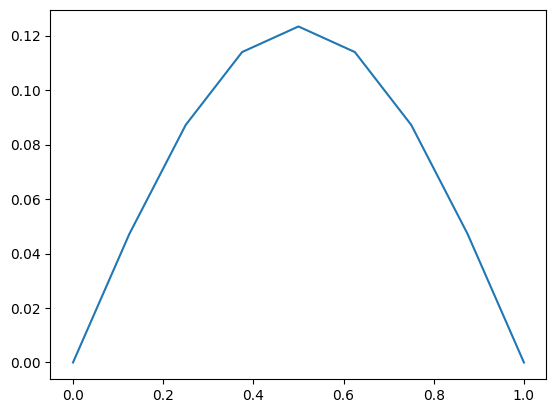

In [17]:
def rhs(N):
    def fun(x,i):
        return [np.sin(np.pi * val) * b(val,i,N) for val in x]
    return [quadrature(fun, (i-1)/(N-1),(i+1)/(N-1), args=i)[0] for i in range(1,N-1)];
N = 9
ax.clear()
f = np.vstack((np.array([[0]]),np.array(rhs(N)).reshape(-1,1),np.array([[0]]))); 
ax.plot(np.linspace(0,1,N),f); display(fig)

# Solve

### We want to solve $-\frac{d^2}{dx^2} u(x) = \sin(\pi x)$ with $u(0)=u(1)=0$ with exact solution: $\frac{1}{\pi^2} \sin(\pi x)$

In [6]:
ax.clear()

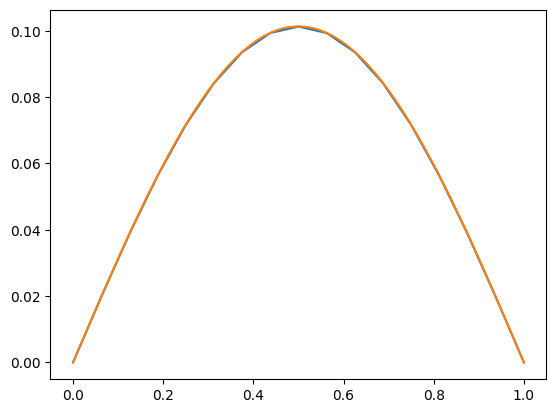

In [21]:
N = 17
A = stiffness_matrix(N)
f = rhs(N)

u = np.linalg.solve(A,f); u = np.vstack((np.array([[0]]),np.array(u).reshape(-1,1),np.array([[0]]))); # compute coefficient vector
ax.clear();ax.plot(np.linspace(0,1,N), u); #plot solution
ax.plot(np.linspace(0,1,100), 1/np.pi/np.pi*np.sin(np.pi*np.linspace(0,1,100)));  display(fig) # plot reference

# Part II
    
## Multigrid Idea

# Multigrid Idea

- Observation and convergence analysis of smoothers show:
    - “high-frequency error” is relative to mesh size
    - on a sufficiently coarse grid, even very low frequencies can be “high-frequency” (if the mesh size is big)
    
- Multigrid idea:
     - use multiple grids to solve the system of equations
     - hope that on each grid, a certain range of error frequencies will be reduced efficiently

# Nested Iteration

### Solve the problem on a coarser grid:
- will be comparably (very) fast
- can give us a good initial guess:
- leads to “poor man’s multigrid”: nested iteration

# Nested Iteration
### Algorithm:
1. Start on a very coarse grid with mesh size $h = h_0$ 

        - guess an initial solution $x_h$
        
2. Iterate over $A_h x_h = b_h$ using relaxation method

        - approximate solution $x_h$
        
3. interpolate the solution $x_h$ to a finer grid with mesh width $h/2$

4. proceed with step 2 (now with mesh size $h := h/2$) using interpolated $x_{h/2}$ as initial solution

# Nested Iteration

### Recall Gauss-Seidel Smoother

In [22]:
def gaussSeidelRelaxation(A, b, x0, maxIter):
    x = x0  # initial guess
    res = b - np.dot(A,x)                        # initial residual
    for i in range(maxIter):
        for j in range(0,x.size):
            x[j] = (1/A[j,j]) * (b[j] - np.dot(A[j,:],x) + A[j,j]*x[j]); # forward substitution and update
        res = b - np.dot(A,x)  
    return x

# Nested Iteration

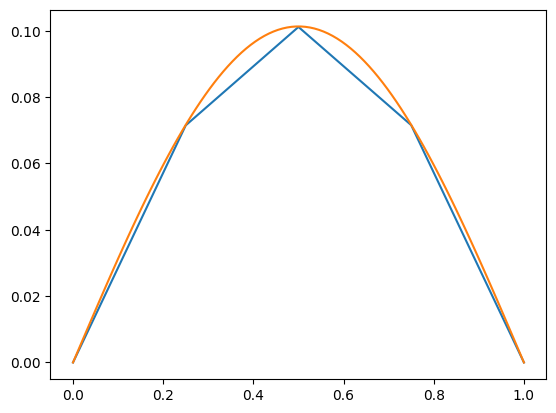

In [28]:
# Get first grid approximation
N = 5; h = 0.25
A = stiffness_matrix(N)
f = rhs(N); x0 = np.zeros(N-2).reshape(-1,1)
u_coarse = gaussSeidelRelaxation(A, f, x0, 10); u_coarse = np.vstack((np.array([[0]]),u_coarse,np.array([[0]])));

ax.clear(); ax.plot(np.linspace(0,1,N), u_coarse); 
ax.plot(np.linspace(0,1,100), 1/np.pi/np.pi*np.sin(np.pi*np.linspace(0,1,100))); display(fig)

# Nested Iteration

### In order to use the result of the coarse grid on a fine grid we need to interpolate

In [8]:
def interpolate(u_coarse):
    u_fine = np.zeros(u_coarse.size*2-1).reshape(-1,1)
    u_fine[::2] = u_coarse # even indices exist on the coarse grid
    u_fine[1::2] = 0.5*(u_coarse[:u_coarse.size-1] + u_coarse[1:]) # linear interpolation
    return u_fine

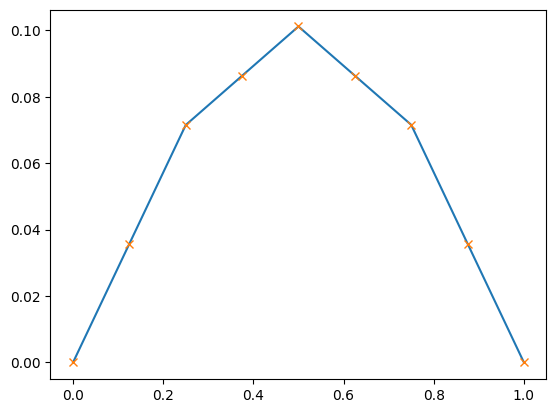

In [31]:
N=9
u_fine = interpolate(u_coarse);
ax.clear(); ax.plot(np.linspace(0,1,5), u_coarse); 
ax.plot(np.linspace(0,1,N), u_fine,"x"); 
display(fig)

# Nested Iteration

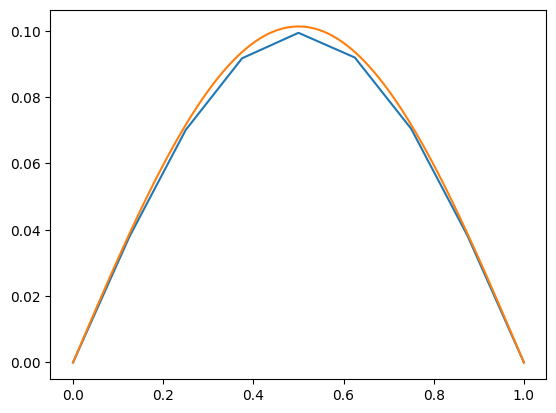

In [34]:
# Use first grid as starting point for refined simulation
N = 9; h = 0.125
A = stiffness_matrix(N)
f = rhs(N); 
#x0 = np.zeros(N-2).reshape(-1,1)
x0 = interpolate(u_coarse)[1:N-1]
u_fine = gaussSeidelRelaxation(A, f, x0, 5); u_fine = np.vstack((np.array([[0]]),u_fine,np.array([[0]])));

ax.clear(); ax.plot(np.linspace(0,1,N), u_fine); 
ax.plot(np.linspace(0,1,100), 1/np.pi/np.pi*np.sin(np.pi*np.linspace(0,1,100))); display(fig)

# Multigrid Idea

### Observation for nested iteration:
- error in interpolated initial guess also includes low frequencies
- relaxation therefore still slow
- can we go “back” to a coarser grid later in the algorithm?

# Multigrid Idea

### Idea No. 2: use the residual equation

##### coarse-grid correction:
- solve Ae = r on a coarser grid
- leads to an approximation of the error e
- add this approximation to the fine-grid solution

# A Two-Grid Method

### Algorithm:
1. relaxation/smoothing on the fine level system $\rightarrow$ solution $x_h$
2. compute the residual $r_h = b_h - A_h x_h$
3. restriction of $r_h$ to the coarse grid with mesh width $H$
4. compute a solution to $A_H e_H = r_H$
5. interpolate the coarse grid solution $e_H$ to the fine grid with mesh width $h$
6. add the resulting correction to $x_h$
7. again, relaxation/smoothing on the fine grid

# Two-Grid Method - Components
### smoother:
- reduce the high-frequency error components, and get a smooth error

### restriction:
- transfer residual from fine grid to coarse grid, e.g. injection, (full) weighting
     
### coarse grid equation:
-  discretisation of the PDE on the coarse grid

### interpolation:
- transfer coarse grid solution/correction from coarse grid to fine grid

# Components

#### We have
- smoother
- coarse grid equation (by direct discretisation $\rightarrow$ other options exist)

#### Missing
- interpolation
- restriction

# Interpolation

- take coarse grid solution and transfer to fine grid
- If transfering from $h \rightarrow h/2$ missing a value for every second coefficient

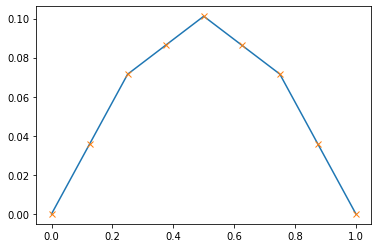

In [619]:
N=9
u_fine = interpolate(u_coarse);
ax.clear(); ax.plot(np.linspace(0,1,5), u_coarse); 
ax.plot(np.linspace(0,1,N), u_fine,"x"); display(fig)

# Interpolation (or Prolongation)

#### In between coarse grid grid points:
1. choose a constant value (ie either value to the side)
     - usually too small approximation error
     - sometimes used for cell-based coarsening (e.g. for FV methods where the cell values are constants)
2. quadratic, cubic, etc.:
      - often too costly
      - more smoothing steps are cheaper and can eliminate the disadvantage of a lower-order interpolation
3. For our current p.w. linear approximation a linear interpolation is reasonable

# Interpolation - Matrix Notation

#### For linear interpolation (1D):
  
$$
  \left(\begin{array}{ccc}
        \frac{1}{2} & 0 & 0 \\
        1 & 0 & 0 \\
        \frac{1}{2} & \frac{1}{2} & 0 \\
        0 & 1 & 0 \\
        0 & \frac{1}{2} & \frac{1}{2} \\
        0 & 0 & 1 \\
        0 & 0 & \frac{1}{2}\\
     \end{array}\right)
     \left(\begin{array}{c}
        x_1 \\ x_2 \\ x_3
\end{array}\right)
=
     \left(\begin{array}{c}
        \frac{1}{2} (0+x_1) \\ x_1 \\ \frac{1}{2} ( x_1+x_2) \\ x_2 \\ 
        \frac{1}{2} ( x_2+x_3) \\ x_3 \\ \frac{1}{2} (x_3+0)
     \end{array}\right)$$
  
#### Notation: $I_{2h} x_{2h} = x_h$ or $P_{2h}x_{2h} = x_h$

#### Note: disregards boundary values (here: 0-Dirichlet condition assumed)

# Interpolation

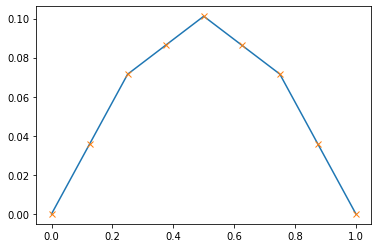

In [620]:
def interpolate(u_coarse):
    u_fine = np.zeros(u_coarse.size*2-1).reshape(-1,1)
    u_fine[::2] = u_coarse # even indices exist on the coarse grid
    u_fine[1::2] = 0.5*(u_coarse[:u_coarse.size-1] + u_coarse[1:]) # linear interpolation
    return u_fine

u_fine = interpolate(u_coarse);
ax.clear(); ax.plot(np.linspace(0,1,5), u_coarse); ax.plot(np.linspace(0,1,9), u_fine,"x"); display(fig)

# Interpolation - Convection-Diffusion

### Example problem: 1D convection-diffusion equation

$$ - \epsilon u_{xx} + c u_{x} = f, \qquad 0 < \epsilon \ll c $$

- consider homogeneous problem ($f=0$) with Dirichlet boundaries: $u(0)=1$, $u(1) = 0$
- exact solution for this case: 

$$ u(x) = \frac{1}{1 - e^{c /\epsilon}} \left( e^{c x /\epsilon} - e^{c /\epsilon} \right) = 1- \frac{ 1- e^{c x /\epsilon} }{1 - e^{c /\epsilon}} $$

# Interpolation - Convection-Diffusion

### Operator-dependent Interpolation:
- interpolate at $x=\frac{1}{2}$:

   $$ u\bigl(\frac{1}{2}\bigr) = 1- \frac{ 1- e^{c /2\epsilon} }{1 - e^{c /\epsilon}} =: 1 - \frac{1-z}{1-z^2} $$ for large $z =e^{\frac{c}{2\epsilon}}$, we have $u\bigl(\frac{1}{2}\bigr) \approx 1 - \frac{1}{z} \approx 1$
   
#### thus: linear interpolation inappropriate (and leads to slow convergence) $\rightarrow$ interpolation should be operator-dependent

# Restriction

### For Poisson problem:
- injection: pick values at corresp. coarse grid points
- full weighting: transpose of bilinear interpolation (safer, more robust convergence), see illustration below for the 1D case

<img src="images/full_weighting.png"></img>

# Restriction - Matrix Notation

### For full weighting (1D):
$$     \frac{1}{2}\left(\!\begin{array}{ccccccc}
        \frac{1}{2} & 1 & \frac{1}{2} & 0 & 0 & 0 & 0\\[0.5ex]
        0 & 0 & \frac{1}{2} & 1 & \frac{1}{2} & 0 & 0\\[0.5ex]
        0 & 0 & 0 & 0 & \frac{1}{2} & 1 & \frac{1}{2}
     \end{array}\!\right) \!\!
     \left(\!\begin{array}{c}
        x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \\ x_6 \\ x_7
     \end{array}\!\right)
     =
     \left(\!\begin{array}{c}
        \frac{1}{4} (x_1+2x_2+x_3) \\[0.5ex] 
        \frac{1}{4} (x_3+2x_4+x_5) \\[0.5ex] 
        \frac{1}{4} (x_5+2x_6+x_7) 
     \end{array}\!\right)$$

#### Notation: $I_{h}^{2h} x_{h} = x_{2h}$ or $R_h^{2h} x_h = x_{2h}$

# Restriction

In [673]:
# Use first grid as starting point for refined simulation
N = 9; h = 0.125
A = stiffness_matrix(N)
f = rhs(N); 
x0 = interpolate(u_coarse)[1:N-1]
u_fine = gaussSeidelRelaxation(A, f, x0, 100); u_fine = np.vstack((np.array([[0]]),u_fine,np.array([[0]])));

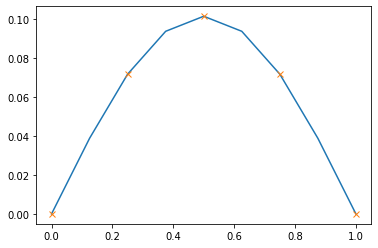

In [677]:
def injection(u_fine):
    N = u_fine.size;   u_coarse = np.zeros(int((N+1)/2)).reshape(-1,1)
    u_coarse = u_fine[0::2]
    return u_coarse
    
u_coarse = injection(u_fine);
ax.clear(); ax.plot(np.linspace(0,1,9), u_fine); 
ax.plot(np.linspace(0,1,5), u_coarse,"x"); display(fig)

# Restriction

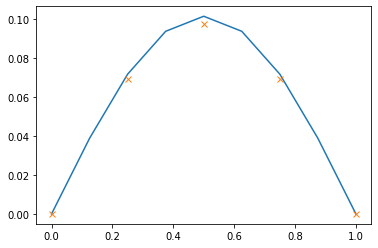

In [683]:
def full_weighting(u_fine):
    N = u_fine.size;     u_f = u_fine[1:N-1]
    u_coarse = np.zeros(int((N+1)/2)).reshape(-1,1)
    u_coarse[1:u_coarse.size-1] = 0.25*(u_f[:N-3][0::2] + 2*u_f[1::2] + u_f[2::2])
    return u_coarse

u_coarse = full_weighting(u_fine);
ax.clear(); ax.plot(np.linspace(0,1,9), u_fine); 
ax.plot(np.linspace(0,1,5), u_coarse,"x"); display(fig)

# Outlook: Multigrid

- Generalise the two grid method to an arbitrary number of grids
- Structure remain: smooth $\rightarrow$ restrict $\rightarrow$ interpolate (repeat)
- V-cycle: recursive call of Two-/Multigrid solver on coarse grids
- W-cycle: perform two coarse grid correction steps instead of one

### Open questions
- Are there other methods of computing the coarse grid operator than discretisation?